# 7장. 여러 개를 분류합니다.

## 07-1 다중 분류 신경망을 만듭니다.

### <직접 해보세요!> 다중 분류 신경망 구현하기

In [2]:
import numpy as np

np.random.seed(42)

In [3]:
class MultiClassNetwork:
    
    def __init__(self, units=10, batch_size=32, learning_rate=0.1, l1=0, l2=0):
        self.units = units         # 은닉층의 뉴런 개수
        self.batch_size = batch_size     # 배치 크기
        self.w1 = None             # 은닉층의 가중치
        self.b1 = None             # 은닉층의 절편
        self.w2 = None             # 출력층의 가중치
        self.b2 = None             # 출력층의 절편
        self.a1 = None             # 은닉층의 활성화 출력
        self.losses = []           # 훈련 손실
        self.val_losses = []       # 검증 손실
        self.lr = learning_rate    # 학습률
        self.l1 = l1               # L1 손실 하이퍼파라미터
        self.l2 = l2               # L2 손실 하이퍼파라미터

    def forpass(self, x):
        z1 = np.dot(x, self.w1) + self.b1        # 첫 번째 층의 선형 식을 계산합니다
        self.a1 = self.sigmoid(z1)               # 활성화 함수를 적용합니다
        z2 = np.dot(self.a1, self.w2) + self.b2  # 두 번째 층의 선형 식을 계산합니다.
        return z2

    def backprop(self, x, err):
        m = len(x)       # 샘플 개수
        # 출력층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w2_grad = np.dot(self.a1.T, err) / m
        b2_grad = np.sum(err) / m
        # 시그모이드 함수까지 그래디언트를 계산합니다.
        err_to_hidden = np.dot(err, self.w2.T) * self.a1 * (1 - self.a1)
        # 은닉층의 가중치와 절편에 대한 그래디언트를 계산합니다.
        w1_grad = np.dot(x.T, err_to_hidden) / m
        b1_grad = np.sum(err_to_hidden, axis=0) / m
        return w1_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        a = 1 / (1 + np.exp(-z))              # 시그모이드 계산
        return a
    
    def softmax(self, z):
        # 소프트맥스 함수
        exp_z = np.exp(z)
        return exp_z / np.sum(exp_z, axis=1).reshape(-1, 1)
 
    def init_weights(self, n_features, n_classes):
        self.w1 = np.random.normal(0, 1, 
                                   (n_features, self.units))  # (특성 개수, 은닉층의 크기)
        self.b1 = np.zeros(self.units)                        # 은닉층의 크기
        self.w2 = np.random.normal(0, 1, 
                                   (self.units, n_classes))   # (은닉층의 크기, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        self.init_weights(x.shape[1], y.shape[1])    # 은닉층과 출력층의 가중치를 초기화합니다.
        # epochs만큼 반복합니다.
        for i in range(epochs):
            print('에포크', i, end=' ')
            # 제너레이터 함수에서 반환한 미니배치를 순환합니다.
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end='')
                self.training(x_batch, y_batch, x_val, y_val)
            print()

    # 미니배치 제너레이터 함수
    def gen_batch(self, x, y):
        bins = len(x) // self.batch_size + 1               # 미니배치 횟수
        indexes = np.random.permutation(np.arange(len(x))) # 인덱스를 섞습니다.
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]   # batch_size만큼 슬라이싱하여 반환합니다.
            
    def training(self, x, y, x_val, y_val):
        m = len(x)                # 샘플 개수를 저장합니다.
        z = self.forpass(x)       # 정방향 계산을 수행합니다.
        a = self.softmax(z)       # 활성화 함수를 적용합니다.
        err = -(y - a)            # 오차를 계산합니다.
        # 오차를 역전파하여 그래디언트를 계산합니다.
        w1_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        # 그래디언트에서 페널티 항의 미분 값을 뺍니다
        w1_grad -= (self.l1 * np.sign(self.w1) + self.l2 * self.w1) / m
        w2_grad -= (self.l1 * np.sign(self.w2) + self.l2 * self.w2) / m
        # 은닉층의 가중치와 절편을 업데이트합니다.
        self.w1 -= self.lr * w1_grad
        self.b1 -= self.lr * b1_grad
        # 출력층의 가중치와 절편을 업데이트합니다.
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad
        # 안전한 로그 계산을 위해 클리핑합니다.
        a = np.clip(a, 1e-10, 1-1e-10)
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        loss = np.sum(-y*np.log(a))
        self.losses.append((loss + self.reg_loss()) / m)
        # 검증 세트에 대한 손실을 계산합니다.
        self.update_val_loss(x_val, y_val)
   
    def predict(self, x):
        z = self.forpass(x)          # 정방향 계산을 수행합니다.
        return np.argmax(z, axis=1)  # 가장 큰 값의 인덱스를 반환합니다.
    
    def score(self, x, y):
        # 예측과 타깃 열 벡터를 비교하여 True의 비율을 반환합니다.
        return np.mean(self.predict(x) == np.argmax(y, axis=1))

    def reg_loss(self):
        # 은닉층과 출력층의 가중치에 규제를 적용합니다.
        return self.l1 * (np.sum(np.abs(self.w1)) + np.sum(np.abs(self.w2))) + \
               self.l2 / 2 * (np.sum(self.w1**2) + np.sum(self.w2**2))

    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)            # 정방향 계산을 수행합니다.
        a = self.softmax(z)                # 활성화 함수를 적용합니다.
        a = np.clip(a, 1e-10, 1-1e-10)     # 출력 값을 클리핑합니다.
        # 크로스 엔트로피 손실과 규제 손실을 더하여 리스트에 추가합니다.
        val_loss = np.sum(-y_val*np.log(a))
        self.val_losses.append((val_loss + self.reg_loss()) / len(y_val))

### <직접 해보세요!> 패션 MNIST 데이터셋 훈련하기

In [4]:
import tensorflow as tf

In [5]:
tf.__version__

'2.0.0-alpha0'

In [6]:
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
print(x_train_all.shape, y_train_all.shape)

(60000, 28, 28) (60000,)


In [8]:
import matplotlib.pyplot as plt

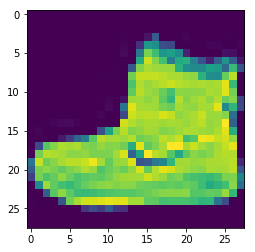

In [9]:
plt.imshow(x_train_all[0])
plt.show()

In [10]:
print(y_train_all[:10])

[9 0 0 3 0 2 7 2 5 5]


In [11]:
class_names = ['티셔츠/윗도리', '바지', '스웨터', '드레스', '코트', 
               '샌들', '셔츠', '스니커즈', '가방', '앵클부츠']

In [12]:
print(class_names[y_train_all[0]])

앵클부츠


In [13]:
np.bincount(y_train_all)

array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000])

In [14]:
from sklearn.model_selection import train_test_split

In [15]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, 
                                                  test_size=0.2, random_state=42)

In [16]:
np.bincount(y_train)

array([4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800, 4800])

In [17]:
np.bincount(y_val)

array([1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200, 1200])

In [18]:
x_train = x_train.reshape(-1, 784)
x_val = x_val.reshape(-1, 784)

In [19]:
print(x_train.shape, x_val.shape)

(48000, 784) (12000, 784)


In [20]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
lb.fit_transform([0, 1, 3, 1])

array([[1, 0, 0],
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [21]:
tf.keras.utils.to_categorical([0, 1, 3])

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [22]:
y_train_encoded = tf.keras.utils.to_categorical(y_train)
y_val_encoded = tf.keras.utils.to_categorical(y_val)

In [23]:
print(y_train_encoded.shape, y_val_encoded.shape)

(48000, 10) (12000, 10)


In [24]:
print(y_train[0], y_train_encoded[0])

6 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [25]:
fc = MultiClassNetwork(units=100, batch_size=128)
fc.fit(x_train[:20000], y_train_encoded[:20000], 
       x_val=x_val[:1000], y_val=y_val_encoded[:1000], epochs=20)

에포크 0 .............................................................................................................................................................
에포크 1 .............................................................................................................................................................
에포크 2 .............................................................................................................................................................
에포크 3 .............................................................................................................................................................
에포크 4 .............................................................................................................................................................
에포크 5 .............................................................................................................................................................
에포크 6 ..........

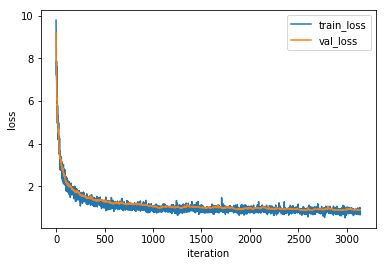

In [26]:
plt.plot(fc.losses)
plt.plot(fc.val_losses)
plt.ylabel('loss')
plt.xlabel('iteration')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [27]:
fc.score(x_val, y_val_encoded)

0.6945

In [28]:
np.random.permutation(np.arange(12000)%10)

array([5, 2, 8, ..., 6, 7, 4])

In [29]:
np.sum(y_val == np.random.permutation(np.arange(12000)%10)) / 12000

0.09908333333333333

## 07-2 텐서플로와 케라스 API를 소개합니다.

### <직접 해보세요!> 텐서플로로 패션 MNIST 데이터셋 훈련하기

In [30]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [31]:
model = Sequential()
model.add(Dense(100, activation='sigmoid', input_shape=(784,)))
model.add(Dense(10, activation='softmax'))

In [32]:
model.compile(optimizer='sgd', loss='categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(x_train, y_train_encoded, epochs=20, 
                    validation_data=(x_val, y_val_encoded))

Train on 48000 samples, validate on 12000 samples
Epoch 1/20
48000/48000 [==============================] - 2s 47us/sample - loss: 1.4290 - accuracy: 0.5990 - val_loss: 1.0844 - val_accuracy: 0.6973
Epoch 2/20
48000/48000 [==============================] - 2s 42us/sample - loss: 0.9663 - accuracy: 0.7226 - val_loss: 0.8823 - val_accuracy: 0.7333
Epoch 3/20
48000/48000 [==============================] - 2s 42us/sample - loss: 0.8309 - accuracy: 0.7477 - val_loss: 0.7897 - val_accuracy: 0.7597
Epoch 4/20
48000/48000 [==============================] - 2s 42us/sample - loss: 0.7546 - accuracy: 0.7670 - val_loss: 0.7197 - val_accuracy: 0.7731
Epoch 5/20
48000/48000 [==============================] - 2s 42us/sample - loss: 0.7035 - accuracy: 0.7785 - val_loss: 0.6736 - val_accuracy: 0.7880
Epoch 6/20
48000/48000 [==============================] - 2s 42us/sample - loss: 0.6639 - accuracy: 0.7890 - val_loss: 0.6418 - val_accuracy: 0.7923
Epoch 7/20
48000/48000 [==============================] 

In [38]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


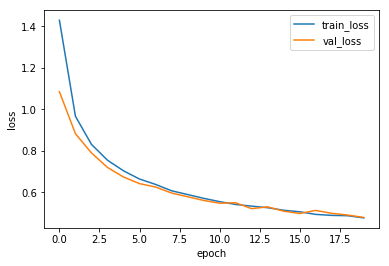

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

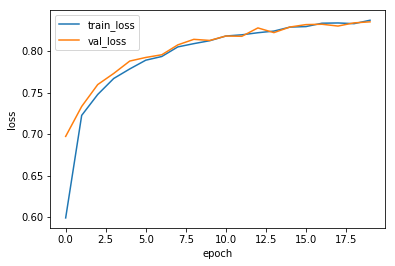

In [40]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [35]:
loss, accuracy = model.evaluate(x_val, y_val_encoded)

12000/12000 [==============================] - 0s 25us/sample - loss: 0.4788 - accuracy: 0.8353


In [37]:
print(accuracy)

0.83525
